# Install required libraries

In [1]:
!pip install nibabel scikit-image

In [3]:
import logging
import os
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, label, binary_closing, binary_opening
from skimage.filters import threshold_otsu, gaussian

# Configure logging


In [4]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

# Create output directory


In [5]:
RESULTS_DIR = '/kaggle/working/results'
os.makedirs(RESULTS_DIR, exist_ok=True)
logging.info(f"Created output directory: {RESULTS_DIR}")

# Verify scikit-image version

In [6]:
import skimage
logging.info(f"scikit-image version: {skimage.__version__}")

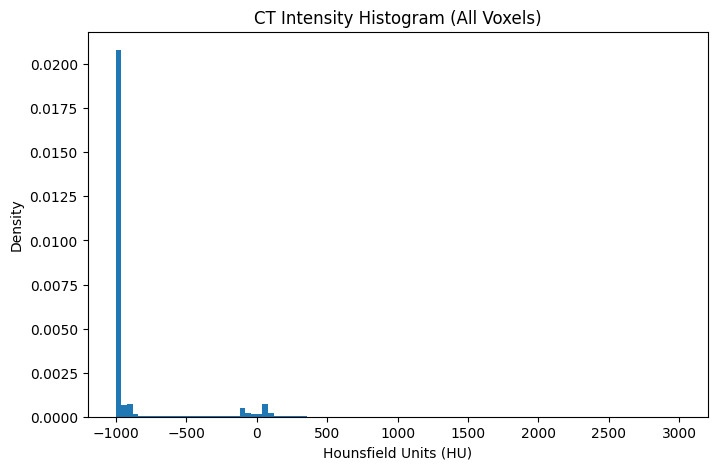

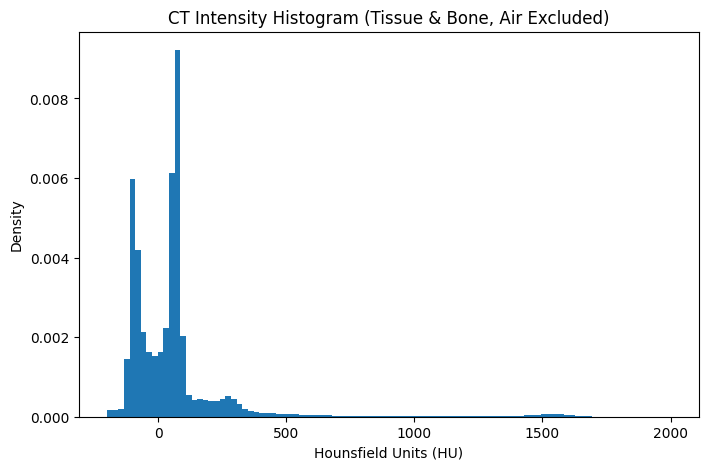

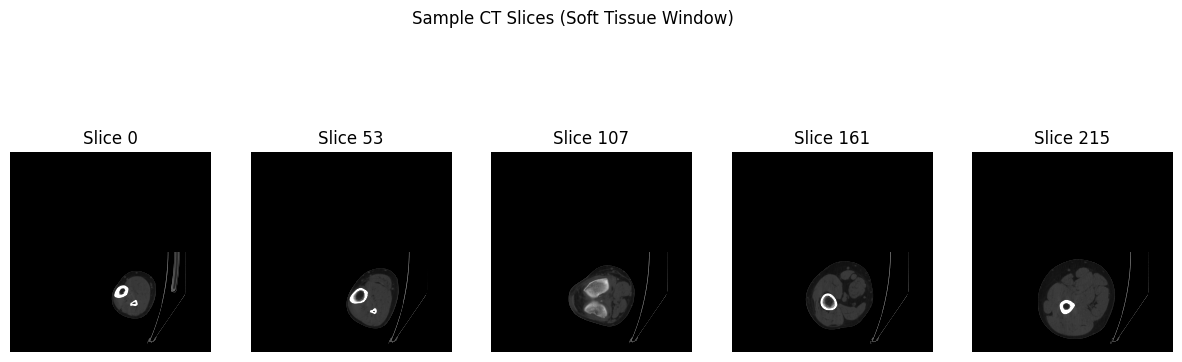

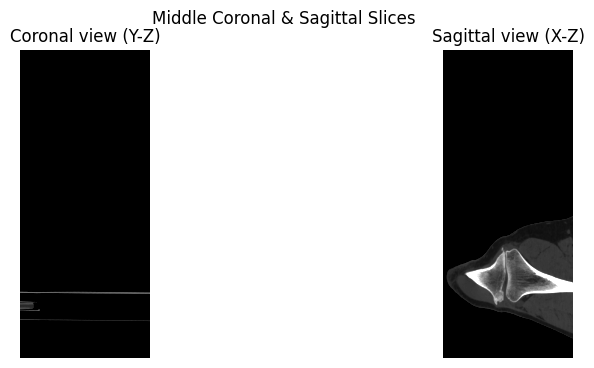

In [7]:
def analyze_ct_data(input_path: str = '/kaggle/input/ra-selection-1-data/3702_left_knee.nii') -> None:
    """
    Analyze the CT scan's properties, visualize histograms, show slices, and basic statistics.
    """
    start_time = time.time()
    logging.info("Starting CT data analysis")

    try:
        # Check input file
        if not os.path.exists(input_path):
            error_msg = (
                f"CT scan not found at {input_path}. Verify with '!ls /kaggle/input/' and update path."
            )
            logging.error(error_msg)
            raise FileNotFoundError(error_msg)

        # Load CT scan
        ct_image = nib.load(input_path)
        ct_data = ct_image.get_fdata().astype(np.float32)
        header = ct_image.header

        # Log properties
        logging.info(f"CT shape: {ct_data.shape}")
        logging.info(f"Voxel sizes (mm): {header.get_zooms()}")
        logging.info(f"Intensity range: {ct_data.min():.2f} to {ct_data.max():.2f} HU")

        # Compute overall stats
        logging.info(f"Mean (all voxels): {ct_data.mean():.2f}")
        logging.info(f"Median (all voxels): {np.median(ct_data):.2f}")
        logging.info(f"Std dev (all voxels): {ct_data.std():.2f}")

        # Histogram: all voxels
        plt.figure(figsize=(8, 5))
        plt.hist(ct_data.ravel(), bins=100, range=(-1000, 3000), density=True)
        plt.title("CT Intensity Histogram (All Voxels)")
        plt.xlabel("Hounsfield Units (HU)")
        plt.ylabel("Density")
        output_path_all = os.path.join(RESULTS_DIR, 'ct_histogram_all.png')
        plt.savefig(output_path_all)
        plt.show()
        logging.info(f"Saved histogram (all voxels): {output_path_all}")

        # Exclude air for tissue & bone view
        air_threshold = -900
        tissue_mask = ct_data > air_threshold
        tissue_data = ct_data[tissue_mask]
        logging.info(f"Non-air voxels: {tissue_data.size}/{ct_data.size} ({100.0 * tissue_data.size / ct_data.size:.2f}%)")
        logging.info(f"Mean (tissue+bone): {tissue_data.mean():.2f}")
        logging.info(f"Median (tissue+bone): {np.median(tissue_data):.2f}")
        logging.info(f"Std dev (tissue+bone): {tissue_data.std():.2f}")

        plt.figure(figsize=(8, 5))
        plt.hist(
            tissue_data.ravel(),
            bins=100,
            range=(-200, 2000),
            density=True
        )
        plt.title("CT Intensity Histogram (Tissue & Bone, Air Excluded)")
        plt.xlabel("Hounsfield Units (HU)")
        plt.ylabel("Density")
        output_path_zoom = os.path.join(RESULTS_DIR, 'ct_histogram_tissue_bone.png')
        plt.savefig(output_path_zoom)
        plt.show()
        logging.info(f"Saved tissue/bone-focused histogram: {output_path_zoom}")

        # Show a few axial slices
        num_slices = 5
        z_indices = np.linspace(0, ct_data.shape[2] - 1, num=num_slices, dtype=int)
        plt.figure(figsize=(15, 5))
        for i, z in enumerate(z_indices):
            plt.subplot(1, num_slices, i + 1)
            plt.imshow(ct_data[:, :, z], cmap='gray', vmin=-200, vmax=1000)
            plt.title(f"Slice {z}")
            plt.axis('off')
        plt.suptitle("Sample CT Slices (Soft Tissue Window)")
        output_path_slices = os.path.join(RESULTS_DIR, 'ct_slices.png')
        plt.savefig(output_path_slices)
        plt.show()
        logging.info(f"Saved sample slices: {output_path_slices}")

        # (Optional) Show one coronal and one sagittal slice
        mid_x = ct_data.shape[0] // 2
        mid_y = ct_data.shape[1] // 2
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(ct_data[mid_x, :, :], cmap='gray', vmin=-200, vmax=1000)
        plt.title('Coronal view (Y-Z)')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(ct_data[:, mid_y, :], cmap='gray', vmin=-200, vmax=1000)
        plt.title('Sagittal view (X-Z)')
        plt.axis('off')
        plt.suptitle("Middle Coronal & Sagittal Slices")
        output_path_planes = os.path.join(RESULTS_DIR, 'ct_middle_planes.png')
        plt.savefig(output_path_planes)
        plt.show()
        logging.info(f"Saved coronal/sagittal slices: {output_path_planes}")

        logging.info(f"CT analysis completed in {time.time() - start_time:.2f} seconds")

    except Exception as e:
        logging.error(f"Failed to analyze CT: {e}")
        raise

# Path to your CT scan file (update if needed)
INPUT_PATH = '/kaggle/input/ra-selection-1-data/3702_left_knee.nii'
analyze_ct_data(INPUT_PATH)

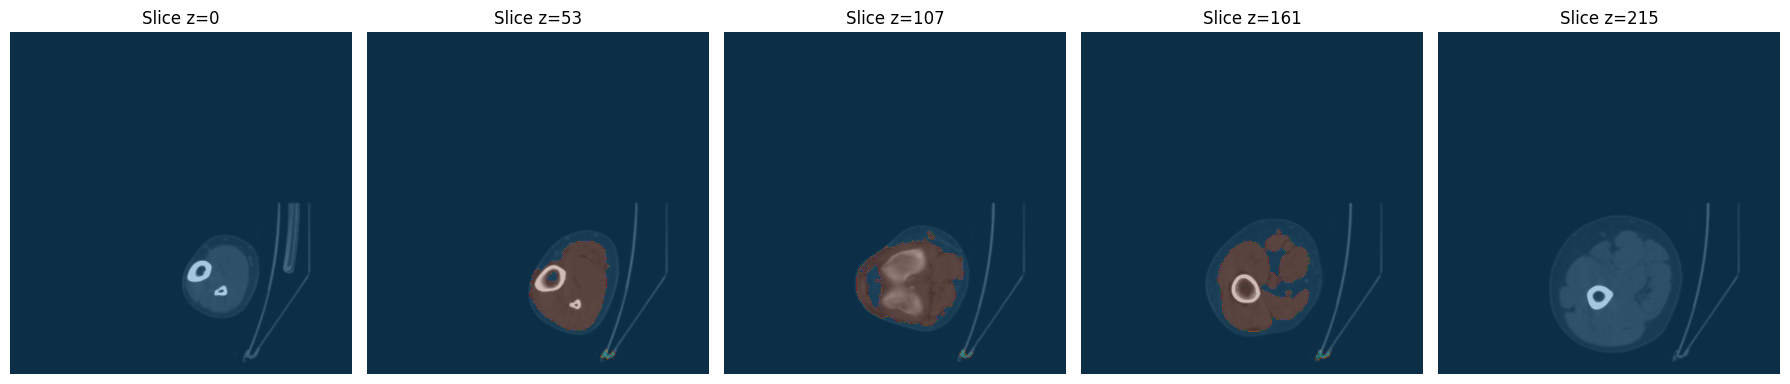

In [14]:
def overlay_segmentation_on_axial(ct_data, segmentation, z_indices):
    plt.figure(figsize=(18, 4))
    for i, z in enumerate(z_indices):
        plt.subplot(1, len(z_indices), i+1)
        plt.imshow(ct_data[:, :, z], cmap='gray', vmin=-200, vmax=1000)
        plt.imshow(segmentation[:, :, z], cmap='tab10', alpha=0.4, vmin=0, vmax=2)
        plt.title(f"Slice z={z}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Use this with the segmentation from your mask function
num_slices = 5
z_indices = np.linspace(0, ct_processed.shape[2] - 1, num=num_slices, dtype=int)
overlay_segmentation_on_axial(ct_processed, segmentation, z_indices)


In [14]:
import os
import time
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_ct(input_path: str = '/kaggle/input/ct-scan/ct_scan.nii.gz') -> tuple[np.ndarray, np.ndarray, nib.Nifti1Header, nib.Nifti1Image]:
    """
    Load a 3D CT scan from file, visualize a mid-slice, and return data, affine, and header.

    Args:
        input_path (str): Path to the CT scan file.

    Returns:
        tuple: (CT data as numpy array, affine matrix, NIfTI header, nib image object).

    Raises:
        FileNotFoundError: If the input file is not found.
        RuntimeError: If loading the NIfTI file fails.
    """
    start_time = time.time()
    logging.info(f"Loading CT from {input_path}")

    try:
        if not os.path.exists(input_path):
            error_msg = (
                f"CT scan not found at {input_path}. Verify with '!ls /kaggle/input/' and update path."
            )
            logging.error(error_msg)
            raise FileNotFoundError(error_msg)

        ct_image = nib.load(input_path)
        ct_data = ct_image.get_fdata().astype(np.float32)
        affine = ct_image.affine
        header = ct_image.header
        logging.info(f"CT shape: {ct_data.shape}, voxel sizes: {header.get_zooms()}")
        logging.info(f"Intensity range: {ct_data.min():.2f} to {ct_data.max():.2f} HU")
        logging.info(f"Loading completed in {time.time() - start_time:.2f} seconds")

        # Visualize a sample slice (soft tissue window for clarity)
        slice_idx = ct_data.shape[2] // 2
        plt.figure(figsize=(6, 6))
        plt.imshow(ct_data[:, :, slice_idx], cmap='gray', vmin=-200, vmax=1000)
        plt.title(f"Mid CT Slice (z={slice_idx}, window -200 to 1000 HU)")
        plt.axis('off')
        output_path = os.path.join(RESULTS_DIR, 'raw_ct_slice.png')
        plt.savefig(output_path)
        logging.info(f"Saved raw CT slice: {output_path}")
        plt.show()

        return ct_data, affine, header, ct_image

    except Exception as e:
        logging.error(f"Failed to load CT: {e}")
        raise



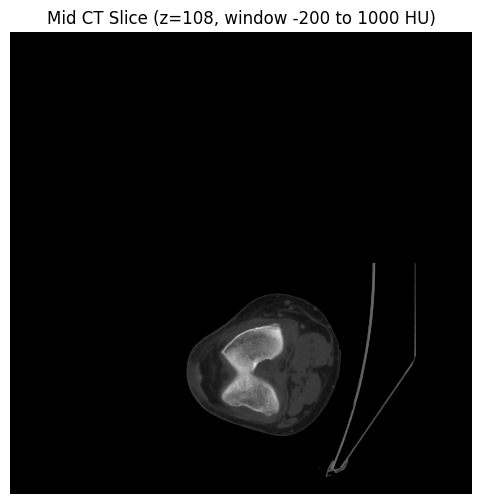

In [15]:
ct_data, affine, header, ct_image = load_ct(INPUT_PATH)


In [21]:
from scipy.ndimage import gaussian_filter

def preprocess_ct(ct_data: np.ndarray, sigma: float = 1.0) -> np.ndarray:
    """
    Preprocess CT data: window, smooth with Gaussian filter to reduce noise.

    Args:
        ct_data (np.ndarray): 3D CT volume in HU.
        sigma (float): Standard deviation for Gaussian filter.

    Returns:
        np.ndarray: Preprocessed (smoothed, windowed) CT volume in HU.

    Raises:
        ValueError: If ct_data is not 3D.
    """
    start_time = time.time()
    logging.info("Starting preprocessing")

    try:
        if ct_data.ndim != 3:
            raise ValueError("Expected 3D CT volume")

        # 1. Window to -200 (fat) to 2000 (bone)
        ct_windowed = np.clip(ct_data, -200, 2000)
        # 2. Denoise
        ct_denoised = gaussian_filter(ct_windowed, sigma=sigma)
        logging.info(f"Preprocessing completed in {time.time() - start_time:.2f} seconds")
        logging.info(f"Denoised intensity range: {ct_denoised.min():.2f} to {ct_denoised.max():.2f}")

        # 3. Visualize a denoised slice (soft tissue window)
        slice_idx = ct_data.shape[2] // 2
        plt.figure(figsize=(6, 6))
        plt.imshow(ct_denoised[:, :, slice_idx], cmap='gray', vmin=-200, vmax=1000)
        plt.title(f"Denoised CT Slice (z={slice_idx}, window -200 to 1000 HU)")
        plt.axis('off')
        output_path = os.path.join(RESULTS_DIR, 'denoised_ct_slice.png')
        plt.savefig(output_path)
        logging.info(f"Saved denoised CT slice: {output_path}")
        plt.show()

        return ct_denoised

    except Exception as e:
        logging.error(f"Preprocessing failed: {e}")
        raise



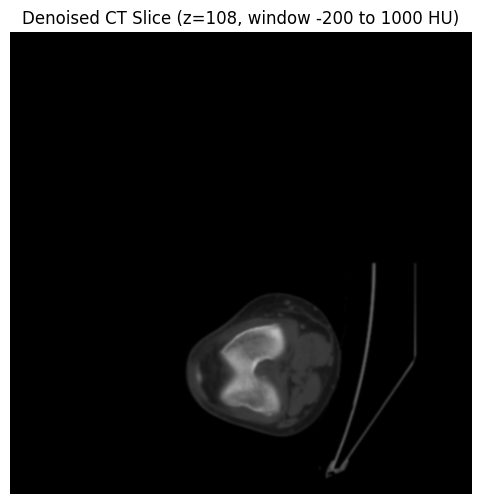

In [22]:
ct_processed = preprocess_ct(ct_data)


In [23]:
from scipy.ndimage import label, binary_opening, binary_closing, binary_fill_holes, center_of_mass
import nibabel as nib
import numpy as np
import os
import time
import logging
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

def threshold_bones(
    ct_data: np.ndarray,
    affine=None,
    header=None,
    save_path=None,
    visualize=True,
    min_voxels=2000,
    assign_fibula=False
) -> np.ndarray:
    """
    Segment femur and tibia from preprocessed 3D CT.
    - Robust to small bone fragments (fibula, patella).
    - Optionally assigns fibula as label=3.
    - Returns: segmentation (1=femur, 2=tibia, 3=fibula if enabled, 0=background)
    """
    start_time = time.time()
    logging.info("Starting femur/tibia segmentation (robust)")

    try:
        if ct_data.ndim != 3:
            raise ValueError("Expected 3D CT volume")

        # Step 1: Bone threshold (Otsu, or override if you want to use HU > 200)
        otsu_thresh = threshold_otsu(ct_data)
        bone_threshold = otsu_thresh * 0.9
        bone_mask = (ct_data > bone_threshold)

        # Step 2: Morphological cleaning
        bone_mask = binary_closing(bone_mask, iterations=3)
        bone_mask = binary_opening(bone_mask, iterations=3)
        bone_mask = binary_fill_holes(bone_mask)

        # Step 3: Label all connected regions
        labeled_mask, num_features = label(bone_mask)
        logging.info(f"Found {num_features} connected bone regions")

        # Step 4: Remove tiny components (keep only large enough to be real bones)
        region_info = []
        for i in range(1, num_features + 1):
            region = (labeled_mask == i)
            size = np.sum(region)
            if size < min_voxels:
                continue  # Skip tiny noise, possible patella/fibula specks
            centroid = center_of_mass(region)
            region_info.append({'label': i, 'size': size, 'centroid': centroid})

        if len(region_info) < 2:
            logging.warning("Less than 2 large components. Only largest is labeled as femur.")
            segmentation = (labeled_mask > 0).astype(np.uint8)
            if save_path and affine is not None and header is not None:
                nib.save(nib.Nifti1Image(segmentation, affine, header), save_path)
            return segmentation

        # Step 5: Sort by size, then vertical position (Y centroid)
        region_info.sort(key=lambda x: x['size'], reverse=True)
        largest_regions = region_info[:3] if assign_fibula and len(region_info) >= 3 else region_info[:2]

        # Assign labels based on centroid vertical (Y axis)
        # Create (idx, y-centroid) list, femur = highest (smallest Y), tibia = next
        largest_regions.sort(key=lambda x: x['centroid'][1])
        femur_label = largest_regions[0]['label']
        tibia_label = largest_regions[1]['label']
        fibula_label = largest_regions[2]['label'] if assign_fibula and len(largest_regions) == 3 else None

        # Step 6: Build output segmentation
        segmentation = np.zeros_like(labeled_mask, dtype=np.uint8)
        segmentation[labeled_mask == femur_label] = 1
        segmentation[labeled_mask == tibia_label] = 2
        if assign_fibula and fibula_label is not None:
            segmentation[labeled_mask == fibula_label] = 3

        # Step 7: Save NIfTI if requested
        if save_path and affine is not None and header is not None:
            seg_img = nib.Nifti1Image(segmentation, affine, header)
            nib.save(seg_img, save_path)
            logging.info(f"Saved segmentation to {save_path}")

        # Step 8: Visualization (optionally overlay masks for multiple slices)
        if visualize:
            mid_slice = ct_data.shape[2] // 2
            plt.figure(figsize=(14, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(ct_data[:, :, mid_slice], cmap='gray', vmin=-200, vmax=1000)
            plt.title(f"CT Slice z={mid_slice}")
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(segmentation[:, :, mid_slice], cmap='tab10', vmin=0, vmax=3)
            plt.title("Segmented: 1=Femur, 2=Tibia" + (", 3=Fibula" if assign_fibula else ""))
            plt.axis('off')
            plt.tight_layout()
            plt.show()

        logging.info(f"Segmentation completed in {time.time() - start_time:.2f} seconds")
        return segmentation

    except Exception as e:
        logging.error(f"Femur/tibia segmentation failed: {e}")
        raise


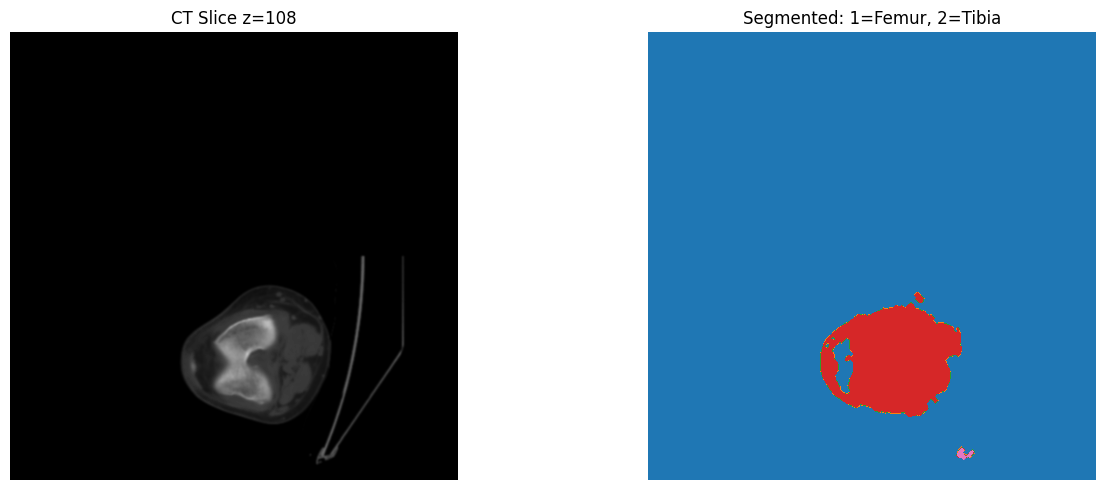

In [24]:
bone_mask = threshold_bones(ct_processed)

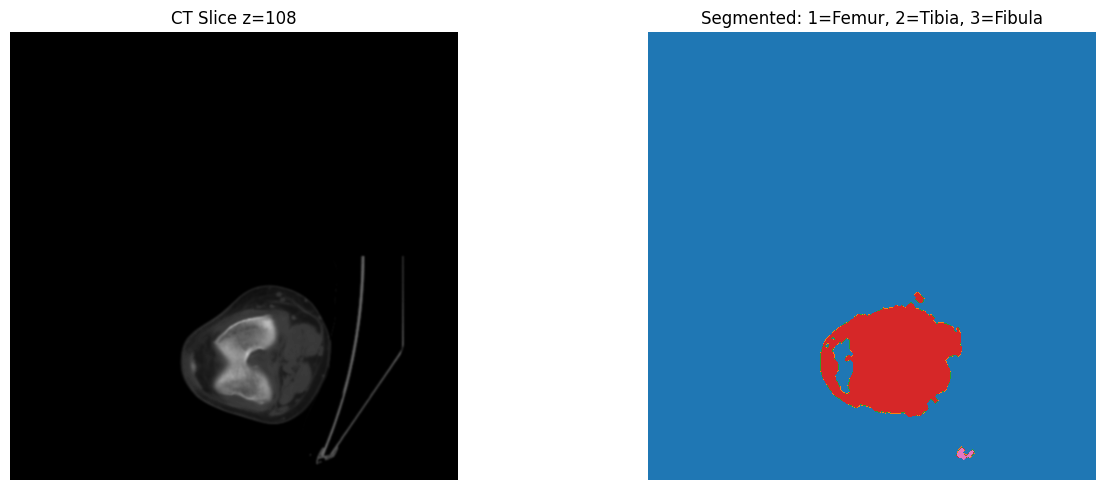

In [25]:
segmentation = threshold_bones(
    ct_denoised, 
    affine, 
    header, 
    save_path=os.path.join(RESULTS_DIR, 'femur_tibia_segmentation.nii.gz'),
    visualize=True,
    min_voxels=2000,      # or adjust as needed
    assign_fibula=True   # set True if you want to try labeling fibula
)


In [26]:
from scipy.ndimage import binary_closing, binary_opening, binary_fill_holes, label
import numpy as np
import logging

def refine_mask(mask: np.ndarray, min_size: int = 1000, fill_holes: bool = True) -> np.ndarray:
    """
    Refine a 3D binary mask: morphological cleaning, optional hole filling, size filtering.
    
    Args:
        mask (np.ndarray): Binary mask to refine (should be 0/1 or 0/True).
        min_size (int): Minimum component size (voxels) to keep.
        fill_holes (bool): Whether to fill holes inside connected objects.

    Returns:
        np.ndarray: Refined mask (uint8).
    """
    if mask.ndim != 3:
        raise ValueError("Expected 3D mask")

    # Binarize, just in case
    mask = (mask > 0).astype(np.uint8)

    # Morphological closing (fills small gaps), opening (removes speckles)
    struct = np.ones((3, 3, 3), dtype=np.uint8)
    mask = binary_closing(mask, structure=struct, iterations=2).astype(np.uint8)
    mask = binary_opening(mask, structure=struct, iterations=1).astype(np.uint8)

    # Fill holes (optional, but helpful for bone)
    if fill_holes:
        mask = binary_fill_holes(mask).astype(np.uint8)

    # Remove small connected components
    labeled, num = label(mask)
    sizes = np.bincount(labeled.ravel())
    # sizes[0] is background, so ignore
    remove_small = np.where(sizes >= min_size)[0]
    remove_small = remove_small[remove_small != 0]  # remove background label
    refined = np.isin(labeled, remove_small).astype(np.uint8)

    logging.info(f"Refined mask: {num} components found, kept {len(remove_small)} above {min_size} voxels.")
    return refined

# Example usage:
# If segmentation is a label map: 0=bg, 1=femur, 2=tibia, 3=fibula...
# Extract binary masks:
femur_mask = refine_mask((segmentation == 1), min_size=1000)
tibia_mask = refine_mask((segmentation == 2), min_size=1000)
fibula_mask = refine_mask((segmentation == 3), min_size=200)  # adjust as needed


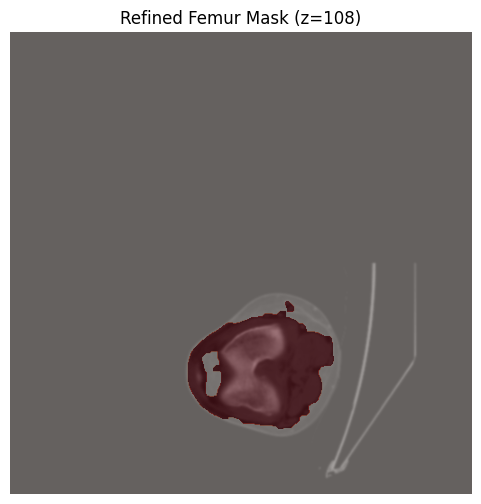

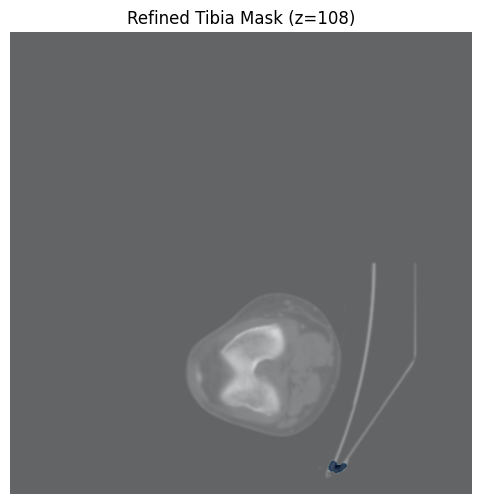

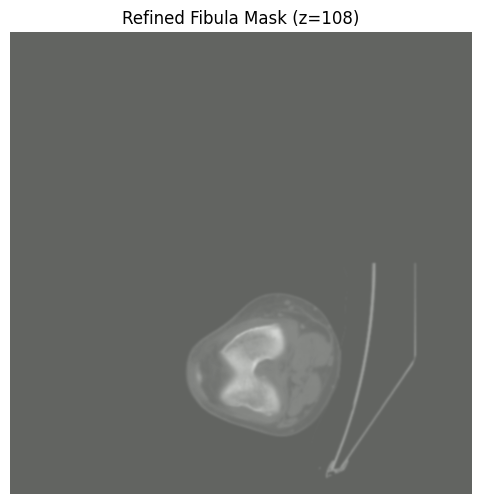

In [27]:
import matplotlib.pyplot as plt

def display_refined_mask(ct_data, mask, z=None, title='Refined Mask Overlay', color='Reds'):
    """
    Overlay a binary mask on a CT slice.
    """
    if z is None:
        z = ct_data.shape[2] // 2  # middle slice
    plt.figure(figsize=(6, 6))
    plt.imshow(ct_data[:, :, z], cmap='gray', vmin=-200, vmax=1000)
    plt.imshow(mask[:, :, z], cmap=color, alpha=0.4)
    plt.title(f"{title} (z={z})")
    plt.axis('off')
    plt.show()

# Example usage after refining:
femur_mask = refine_mask((segmentation == 1), min_size=1000)
tibia_mask = refine_mask((segmentation == 2), min_size=1000)
fibula_mask = refine_mask((segmentation == 3), min_size=200)

display_refined_mask(ct_denoised, femur_mask, title='Refined Femur Mask', color='Reds')
display_refined_mask(ct_denoised, tibia_mask, title='Refined Tibia Mask', color='Blues')
display_refined_mask(ct_denoised, fibula_mask, title='Refined Fibula Mask', color='Greens')


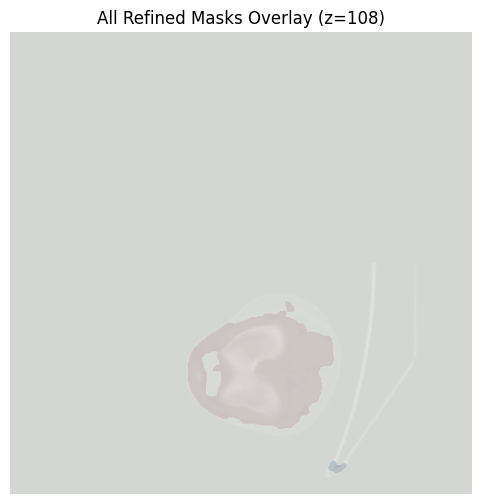

In [28]:
z = 108  # Or any other slice you want to inspect
plt.figure(figsize=(6, 6))
plt.imshow(ct_denoised[:, :, z], cmap='gray', vmin=-200, vmax=1000)
plt.imshow(femur_mask[:, :, z], cmap='Reds', alpha=0.4)
plt.imshow(tibia_mask[:, :, z], cmap='Blues', alpha=0.4)
plt.imshow(fibula_mask[:, :, z], cmap='Greens', alpha=0.6)
plt.title(f"All Refined Masks Overlay (z={z})")
plt.axis('off')
plt.show()


In [31]:
import numpy as np
import logging
from scipy.ndimage import center_of_mass

def validate_anatomy(
    femur_mask: np.ndarray,
    tibia_mask: np.ndarray,
    axis: int = 2  # Default: z-axis (axial)
) -> tuple[np.ndarray, np.ndarray]:
    """
    Validate femur (superior) and tibia (inferior) label assignment based on centroid along axis.
    Swaps masks if detected order is anatomically inconsistent.

    Args:
        femur_mask (np.ndarray): Binary mask for femur.
        tibia_mask (np.ndarray): Binary mask for tibia.
        axis (int): Axis for superior-inferior (default: z=2 for axial slices).

    Returns:
        tuple: (Validated femur mask, validated tibia mask).
    """
    if femur_mask.ndim != 3 or tibia_mask.ndim != 3:
        raise ValueError("Expected 3D masks")
    
    # Compute centroid along the chosen axis
    def centroid(mask):
        if np.any(mask):
            return center_of_mass(mask)[axis]
        else:
            return None

    femur_centroid = centroid(femur_mask)
    tibia_centroid = centroid(tibia_mask)
    
    if femur_centroid is None or tibia_centroid is None:
        logging.warning("One of the masks is empty; skipping validation.")
        return femur_mask, tibia_mask

    # In axial CT, femur (superior) should be higher (larger z)
    if femur_centroid < tibia_centroid:
        logging.warning(
            f"Femur centroid ({femur_centroid:.1f}) is inferior to tibia centroid ({tibia_centroid:.1f}). Swapping labels!"
        )
        return tibia_mask, femur_mask
    else:
        logging.info(
            f"Femur centroid ({femur_centroid:.1f}) is superior to tibia centroid ({tibia_centroid:.1f}). Labels OK."
        )
        return femur_mask, tibia_mask

# Example usage:
femur_mask, tibia_mask = validate_anatomy(femur_mask, tibia_mask, axis=2)


In [33]:
import matplotlib.pyplot as plt

def display_validated_bone_masks(ct_data, femur_mask, tibia_mask, z=None):
    if z is None:
        z = ct_data.shape[2] // 2
    plt.figure(figsize=(7, 7))
    plt.imshow(ct_data[:, :, z], cmap='gray', vmin=-200, vmax=1000)
    plt.imshow(femur_mask[:, :, z], cmap='Reds', alpha=0.4, label='Femur')
    plt.imshow(tibia_mask[:, :, z], cmap='Blues', alpha=0.4, label='Tibia')
    plt.title(f"Validated Femur (red) and Tibia (blue) Masks (z={z})")
    plt.axis('off')
    plt.show()


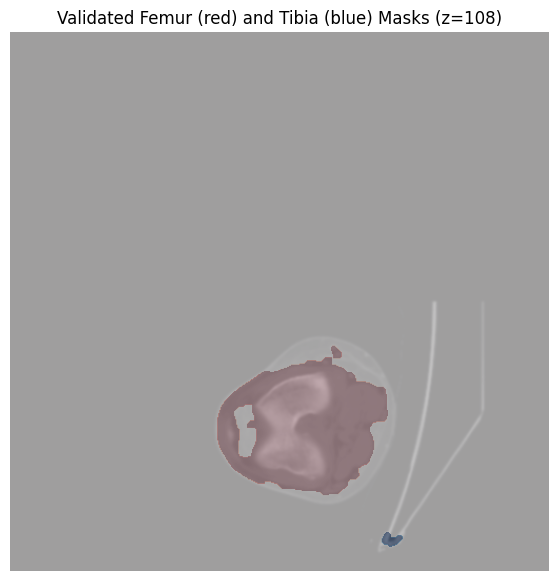

In [34]:
display_validated_bone_masks(ct_denoised, femur_mask, tibia_mask, z=108)  # Or your favorite slice


In [35]:
def display_all_validated_masks(ct_data, femur_mask, tibia_mask, fibula_mask=None, z=None):
    if z is None:
        z = ct_data.shape[2] // 2
    plt.figure(figsize=(7, 7))
    plt.imshow(ct_data[:, :, z], cmap='gray', vmin=-200, vmax=1000)
    plt.imshow(femur_mask[:, :, z], cmap='Reds', alpha=0.4)
    plt.imshow(tibia_mask[:, :, z], cmap='Blues', alpha=0.4)
    if fibula_mask is not None:
        plt.imshow(fibula_mask[:, :, z], cmap='Greens', alpha=0.5)
    plt.title(f"Validated Masks: Femur (Red), Tibia (Blue)" + (", Fibula (Green)" if fibula_mask is not None else "") + f" (z={z})")
    plt.axis('off')
    plt.show()


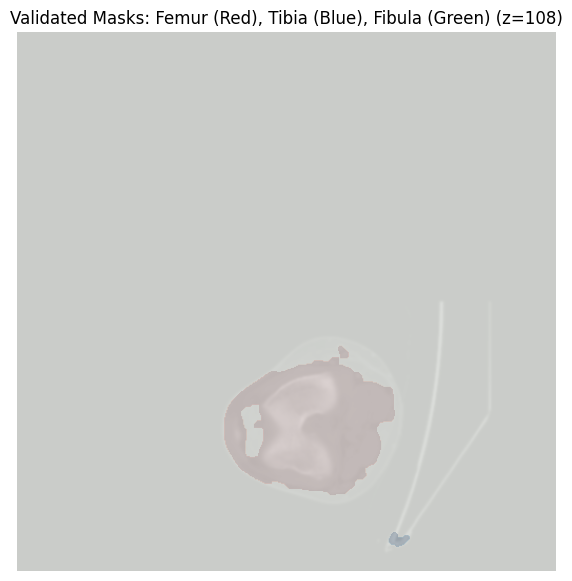

In [36]:
display_all_validated_masks(ct_denoised, femur_mask, tibia_mask, fibula_mask, z=108)

In [37]:
import os
import nibabel as nib
import numpy as np
import logging

def save_nifti(mask: np.ndarray, path: str, affine: np.ndarray, header: nib.Nifti1Header) -> None:
    """
    Save (binary or label) mask as .nii.gz file with correct type and header.

    Args:
        mask (np.ndarray): Binary or label mask to save.
        path (str): Output file path.
        affine (np.ndarray): Affine matrix from original CT.
        header (nib.Nifti1Header): NIfTI header from original CT.

    Raises:
        RuntimeError: If saving fails.
    """
    try:
        # Ensure output is uint8 for masks (saves space and is standard)
        mask_uint8 = mask.astype(np.uint8)
        # Optionally fix datatype in header (avoids warnings in ITK, 3D Slicer, etc.)
        new_header = header.copy()
        new_header.set_data_dtype(np.uint8)
        # Make sure output directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)
        # Save
        nifti_img = nib.Nifti1Image(mask_uint8, affine, new_header)
        nib.save(nifti_img, path)
        logging.info(f"Saved mask as NIfTI: {path} (shape: {mask.shape}, dtype: uint8)")
    except Exception as e:
        logging.error(f"Failed to save mask: {e}")
        raise RuntimeError(f"Error saving mask to {path}")

# Example usage:
save_nifti(femur_mask, os.path.join(RESULTS_DIR, 'femur_mask.nii.gz'), affine, header)
save_nifti(tibia_mask, os.path.join(RESULTS_DIR, 'tibia_mask.nii.gz'), affine, header)
save_nifti(fibula_mask, os.path.join(RESULTS_DIR, 'fibula_mask.nii.gz'), affine, header)


Fibula not present at z=108. Showing z=3 where fibula appears.


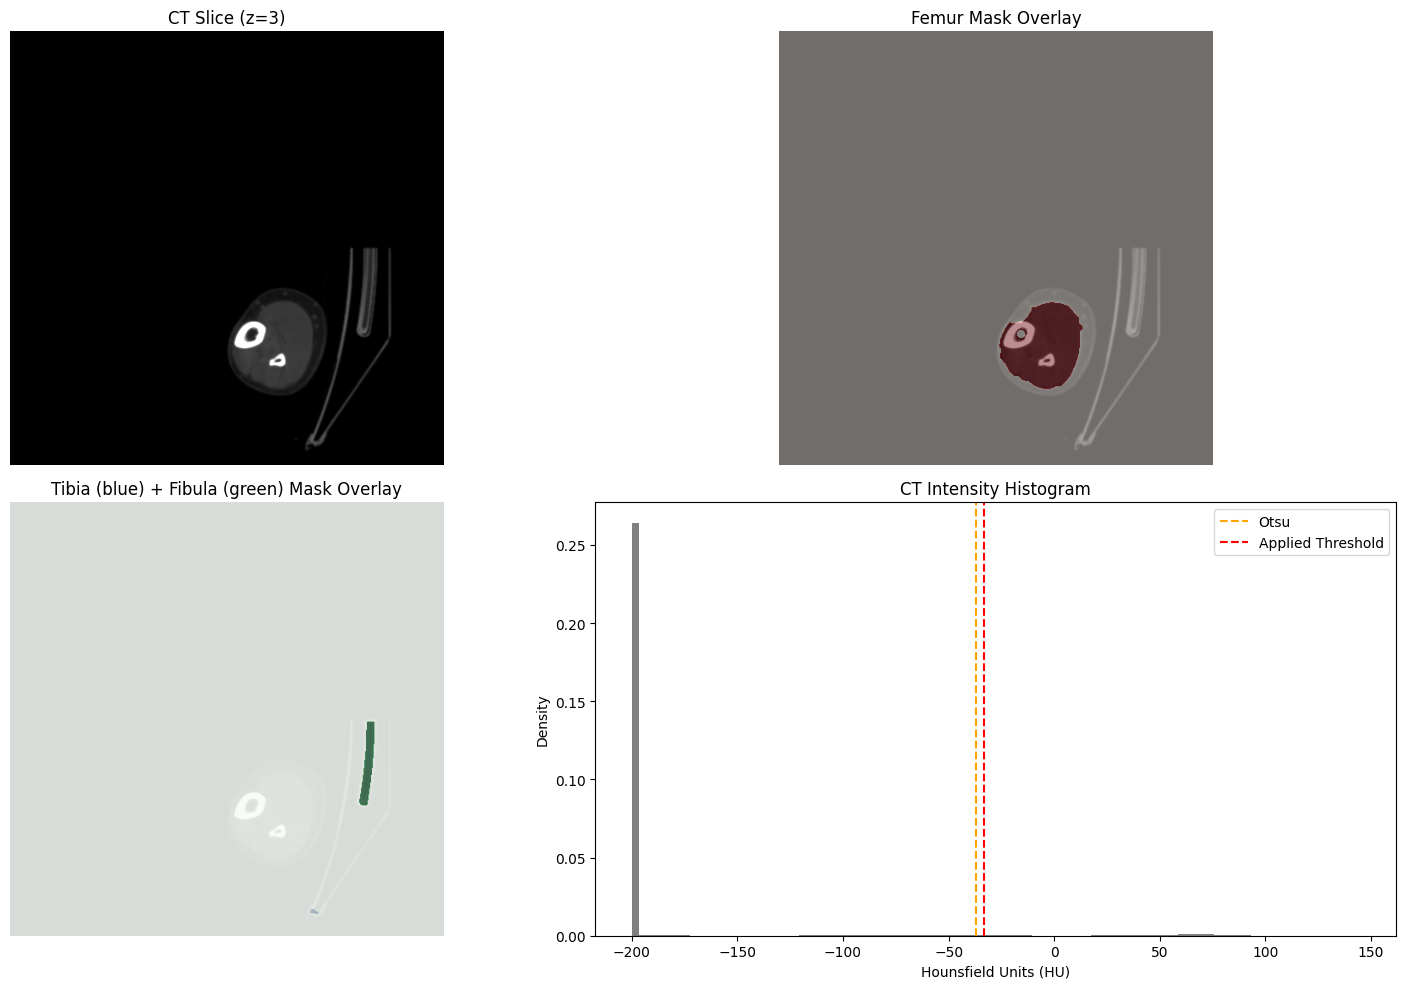

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.filters import threshold_otsu

def find_nonzero_slice(mask, axis=2):
    """Find first slice along given axis with nonzero mask."""
    for z in range(mask.shape[axis]):
        if np.sum(mask.take(z, axis=axis)) > 0:
            return z
    return None

def visualize_results(
    ct_data: np.ndarray,
    femur_mask: np.ndarray,
    tibia_mask: np.ndarray,
    fibula_mask: np.ndarray = None,
    slice_idx: int = None,
    otsu_factor: float = 0.9
) -> None:
    """
    Visualize CT slice, femur/tibia(/fibula) masks, and intensity histogram.
    If tibia (or fibula) not present at slice_idx, finds a slice where they are present.
    """
    if ct_data.ndim != 3 or femur_mask.ndim != 3 or tibia_mask.ndim != 3:
        raise ValueError("Expected 3D inputs")
    if slice_idx is None:
        slice_idx = ct_data.shape[2] // 2

    # --- Find a slice where tibia and/or fibula are visible if not present in this slice
    if np.sum(tibia_mask[:, :, slice_idx]) == 0:
        alt_tibia_slice = find_nonzero_slice(tibia_mask)
        if alt_tibia_slice is not None:
            print(f"Tibia not present at z={slice_idx}. Showing z={alt_tibia_slice} where tibia appears.")
            slice_idx = alt_tibia_slice
    if fibula_mask is not None and np.sum(fibula_mask[:, :, slice_idx]) == 0:
        alt_fibula_slice = find_nonzero_slice(fibula_mask)
        if alt_fibula_slice is not None:
            print(f"Fibula not present at z={slice_idx}. Showing z={alt_fibula_slice} where fibula appears.")
            slice_idx = alt_fibula_slice

    plt.figure(figsize=(16, 10))

    # 1. CT slice
    plt.subplot(2, 2, 1)
    plt.imshow(ct_data[:, :, slice_idx], cmap='gray', vmin=-200, vmax=1000)
    plt.title(f"CT Slice (z={slice_idx})")
    plt.axis('off')

    # 2. Femur mask overlay
    plt.subplot(2, 2, 2)
    plt.imshow(ct_data[:, :, slice_idx], cmap='gray', vmin=-200, vmax=1000)
    plt.imshow(femur_mask[:, :, slice_idx], cmap='Reds', alpha=0.45)
    plt.title("Femur Mask Overlay")
    plt.axis('off')

    # 3. Tibia (+fibula) mask overlay
    plt.subplot(2, 2, 3)
    plt.imshow(ct_data[:, :, slice_idx], cmap='gray', vmin=-200, vmax=1000)
    tibia_present = np.sum(tibia_mask[:, :, slice_idx]) > 0
    if tibia_present:
        plt.imshow(tibia_mask[:, :, slice_idx], cmap='Blues', alpha=0.65)
    fibula_present = fibula_mask is not None and np.sum(fibula_mask[:, :, slice_idx]) > 0
    if fibula_present:
        plt.imshow(fibula_mask[:, :, slice_idx], cmap='Greens', alpha=0.65)
    if tibia_present and fibula_present:
        plt.title("Tibia (blue) + Fibula (green) Mask Overlay")
    elif tibia_present:
        plt.title("Tibia Mask Overlay")
    elif fibula_present:
        plt.title("Fibula Mask Overlay")
    else:
        plt.title("No Tibia/Fibula in this slice")
    plt.axis('off')

    # 4. Intensity histogram
    plt.subplot(2, 2, 4)
    data_flat = ct_data[ct_data > -1000].ravel()
    plt.hist(data_flat, bins=100, range=(np.percentile(data_flat, 1), np.percentile(data_flat, 99)), density=True, color='gray')
    otsu_val = threshold_otsu(ct_data)
    plt.axvline(otsu_val, color='orange', linestyle='--', label='Otsu')
    plt.axvline(otsu_val * otsu_factor, color='red', linestyle='--', label='Applied Threshold')
    plt.title("CT Intensity Histogram")
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Density")
    plt.legend()

    plt.tight_layout()
    output_path = os.path.join(RESULTS_DIR, 'segmentation_preview.png')
    plt.savefig(output_path)
    logging.info(f"Saved visualization: {output_path}")
    plt.show()

# Example usage
visualize_results(
    ct_processed, 
    femur_mask, 
    tibia_mask, 
    fibula_mask if 'fibula_mask' in locals() else None, 
    slice_idx=108
)


In [42]:
def verify_outputs(femur_mask=None, tibia_mask=None, fibula_mask=None) -> None:
    """
    Verify that output files exist and masks are valid.

    Raises:
        FileNotFoundError: If output files are missing.
        ValueError: If masks overlap or are empty.
    """
    # Paths
    femur_path = os.path.join(RESULTS_DIR, 'femur_mask.nii.gz')
    tibia_path = os.path.join(RESULTS_DIR, 'tibia_mask.nii.gz')
    viz_path = os.path.join(RESULTS_DIR, 'segmentation_preview.png')
    paths = [femur_path, tibia_path, viz_path]
    if fibula_mask is not None:
        fibula_path = os.path.join(RESULTS_DIR, 'fibula_mask.nii.gz')
        paths.append(fibula_path)
    
    # Check file existence
    for path in paths:
        if not os.path.exists(path):
            msg = f"Output missing: {path}"
            print(msg)
            logging.error(msg)
            raise FileNotFoundError(msg)
        else:
            print(f"File exists: {path}")

    # Check mask validity (if masks are passed in)
    if femur_mask is not None and tibia_mask is not None:
        overlap = np.sum((femur_mask > 0) & (tibia_mask > 0))
        if overlap > 0:
            msg = f"Femur and tibia masks overlap in {overlap} voxels"
            print(msg)
            raise ValueError(msg)
        femur_voxels = np.sum(femur_mask)
        tibia_voxels = np.sum(tibia_mask)
        if femur_voxels < 1000 or tibia_voxels < 1000:
            msg = f"Masks may be too small; femur: {femur_voxels}, tibia: {tibia_voxels}"
            print(msg)
            logging.warning(msg)
        else:
            print(f"Femur mask voxels: {femur_voxels}, Tibia mask voxels: {tibia_voxels}")

    if fibula_mask is not None:
        # Check fibula mask for overlap and size
        if np.sum((fibula_mask > 0) & (femur_mask > 0)):
            msg = "Femur and fibula masks overlap"
            print(msg)
            raise ValueError(msg)
        if np.sum((fibula_mask > 0) & (tibia_mask > 0)):
            msg = "Tibia and fibula masks overlap"
            print(msg)
            raise ValueError(msg)
        fibula_voxels = np.sum(fibula_mask)
        if fibula_voxels > 0 and fibula_voxels < 200:
            msg = f"Fibula mask is present but very small ({fibula_voxels} voxels)"
            print(msg)
            logging.warning(msg)
        else:
            print(f"Fibula mask voxels: {fibula_voxels}")

    msg = "Output verification passed."
    print(msg)
    logging.info(msg)


In [43]:
verify_outputs(femur_mask=femur_mask, tibia_mask=tibia_mask, fibula_mask=fibula_mask if 'fibula_mask' in locals() else None)


File exists: /kaggle/working/results/femur_mask.nii.gz
File exists: /kaggle/working/results/tibia_mask.nii.gz
File exists: /kaggle/working/results/segmentation_preview.png
File exists: /kaggle/working/results/fibula_mask.nii.gz
Femur mask voxels: 2747762, Tibia mask voxels: 36109
Fibula mask voxels: 30265
Output verification passed.


In [44]:
from scipy.ndimage import binary_dilation

def expand_mask(mask: np.ndarray, voxel_sizes: tuple, expand_mm: float = 2.0, connectivity: int = 1) -> np.ndarray:
    """
    Expand a binary mask outward by a given number of millimeters.

    Args:
        mask (np.ndarray): Binary mask (3D).
        voxel_sizes (tuple): Voxel size in mm, from CT header (z, y, x).
        expand_mm (float): Expansion distance in mm.
        connectivity (int): Structuring element connectivity for dilation (1=6-connected, 2=18, 3=26).

    Returns:
        np.ndarray: Expanded binary mask (uint8).
    """
    if mask.ndim != 3:
        raise ValueError("Expected 3D mask")
    # Calculate expansion in voxels for each dimension
    # Note: voxel_sizes = (z, y, x) as from header.get_zooms()
    z_mm, y_mm, x_mm = voxel_sizes
    # Take the minimum voxel size for isotropic dilation (safe approach)
    min_voxel = min(z_mm, y_mm, x_mm)
    n_iter = int(np.ceil(expand_mm / min_voxel))
    print(f"Expanding mask by {expand_mm}mm ≈ {n_iter} voxel iterations (voxel size: {voxel_sizes})")

    # Build structuring element (cube by default)
    struct = np.ones((3, 3, 3), dtype=np.uint8) if connectivity == 1 else None

    expanded = binary_dilation(mask, structure=struct, iterations=n_iter).astype(np.uint8)
    return expanded

# Example usage:
voxel_sizes = header.get_zooms()  # (z, y, x) or (x, y, z) depending on orientation—check nibabel
expand_mm = 2.0

# For femur:
femur_mask_expanded = expand_mask(femur_mask, voxel_sizes, expand_mm=expand_mm)
# For tibia:
tibia_mask_expanded = expand_mask(tibia_mask, voxel_sizes, expand_mm=expand_mm)
# For fibula (if needed):
fibula_mask_expanded = expand_mask(fibula_mask, voxel_sizes, expand_mm=expand_mm)


Expanding mask by 2.0mm ≈ 3 voxel iterations (voxel size: (0.869141, 0.869141, 2.0))
Expanding mask by 2.0mm ≈ 3 voxel iterations (voxel size: (0.869141, 0.869141, 2.0))
Expanding mask by 2.0mm ≈ 3 voxel iterations (voxel size: (0.869141, 0.869141, 2.0))


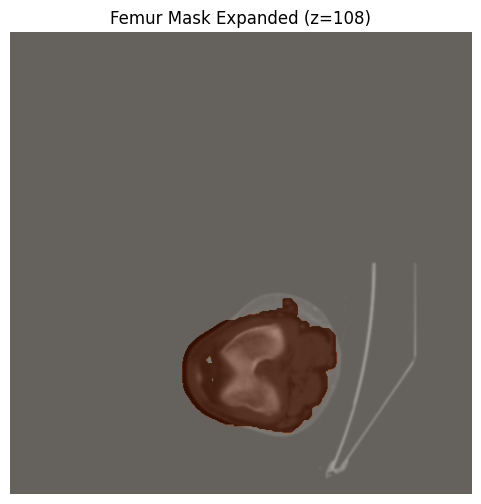

In [45]:
display_refined_mask(ct_denoised, femur_mask_expanded, title='Femur Mask Expanded', color='Oranges')

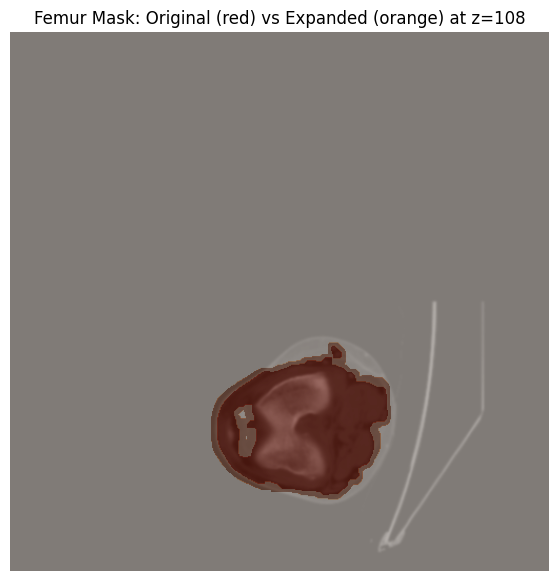

In [47]:
# Example: set slice_idx to the middle slice in z-direction
slice_idx = ct_denoised.shape[2] // 2

plt.figure(figsize=(7, 7))
plt.imshow(ct_denoised[:, :, slice_idx], cmap='gray', vmin=-200, vmax=1000)
plt.imshow(femur_mask[:, :, slice_idx], cmap='Reds', alpha=0.3, label='Original')
plt.imshow(femur_mask_expanded[:, :, slice_idx], cmap='Oranges', alpha=0.3, label='Expanded')
plt.title(f"Femur Mask: Original (red) vs Expanded (orange) at z={slice_idx}")
plt.axis('off')
plt.show()


In [48]:
# Save expanded masks if needed
save_nifti(femur_mask_expanded, os.path.join(RESULTS_DIR, 'femur_mask_expanded.nii.gz'), affine, header)
save_nifti(tibia_mask_expanded, os.path.join(RESULTS_DIR, 'tibia_mask_expanded.nii.gz'), affine, header)
if fibula_mask is not None:
    save_nifti(fibula_mask_expanded, os.path.join(RESULTS_DIR, 'fibula_mask_expanded.nii.gz'), affine, header)


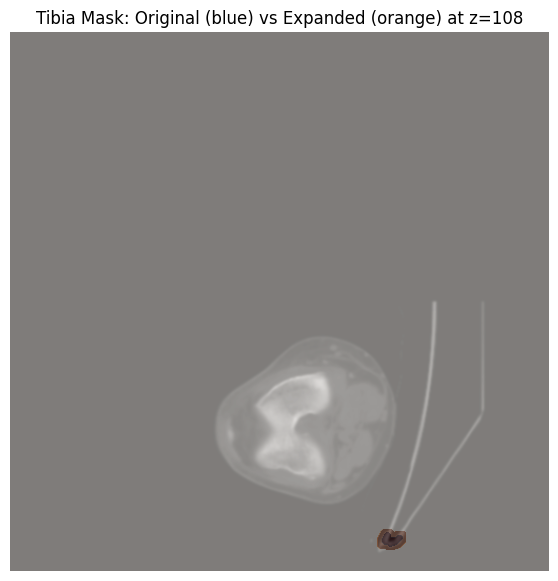

In [49]:
plt.figure(figsize=(7, 7))
plt.imshow(ct_denoised[:, :, slice_idx], cmap='gray', vmin=-200, vmax=1000)
plt.imshow(tibia_mask[:, :, slice_idx], cmap='Blues', alpha=0.3)
plt.imshow(tibia_mask_expanded[:, :, slice_idx], cmap='Oranges', alpha=0.3)
plt.title(f"Tibia Mask: Original (blue) vs Expanded (orange) at z={slice_idx}")
plt.axis('off')
plt.show()

In [52]:
import numpy as np

def randomize_mask(original_mask, expanded_mask, random_fraction=0.5, seed=None):
    """
    Randomizes the mask contour between original and expanded mask.

    Args:
        original_mask (np.ndarray): Binary mask (uint8), original.
        expanded_mask (np.ndarray): Binary mask (uint8), expanded.
        random_fraction (float): Fraction of the "band" to add [0..1].
        seed (int, optional): Random seed for reproducibility.

    Returns:
        np.ndarray: Randomized mask (uint8).
    """
    assert original_mask.shape == expanded_mask.shape, "Shape mismatch"
    rng = np.random.default_rng(seed)
    
    # Find band region
    band = (expanded_mask.astype(np.uint8) - original_mask.astype(np.uint8)) > 0

    # Indices of all band voxels
    band_indices = np.array(np.where(band)).T

    # How many to sample?
    n_band_voxels = len(band_indices)
    n_to_sample = int(n_band_voxels * random_fraction)

    # Randomly pick some indices
    selected = np.zeros(band.shape, dtype=bool)
    if n_to_sample > 0:
        chosen_idx = rng.choice(n_band_voxels, n_to_sample, replace=False)
        selected_voxels = band_indices[chosen_idx]
        selected[tuple(selected_voxels.T)] = True

    # Combine with original
    randomized_mask = (original_mask | selected).astype(np.uint8)
    return randomized_mask


In [53]:
random_fraction = 0.3   # [0 = no change, 1 = full expansion]
randomized_femur_mask = randomize_mask(femur_mask, femur_mask_expanded, random_fraction=random_fraction, seed=42)


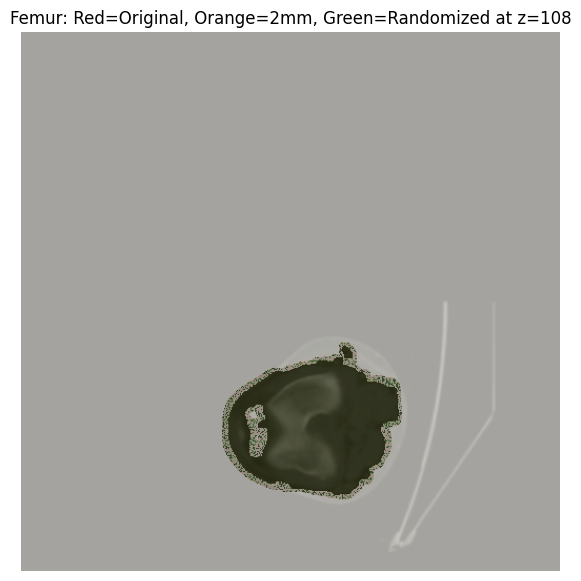

In [54]:
plt.figure(figsize=(7, 7))
plt.imshow(ct_denoised[:, :, slice_idx], cmap='gray', vmin=-200, vmax=1000)
plt.imshow(femur_mask[:, :, slice_idx], cmap='Reds', alpha=0.25, label='Original')
plt.imshow(femur_mask_expanded[:, :, slice_idx], cmap='Oranges', alpha=0.25, label='Expanded')
plt.imshow(randomized_femur_mask[:, :, slice_idx], cmap='Greens', alpha=0.4, label='Randomized')
plt.title(f"Femur: Red=Original, Orange=2mm, Green=Randomized at z={slice_idx}")
plt.axis('off')
plt.show()


In [ ]:
save_nifti(randomized_femur_mask, os.path.join(RESULTS_DIR, 'randomized_femur_mask.nii.gz'), affine, header)


In [ ]:
from scipy.ndimage import binary_dilation
import nibabel as nib

# 1. Original Mask
original_mask = tibia_mask.astype(np.uint8)

# 2. 2mm Expanded Mask
voxel_size = header.get_zooms()[0]  # assume isotropic or use mean(header.get_zooms())
n_iter_2mm = int(np.ceil(2 / voxel_size))
mask_2mm = binary_dilation(original_mask, iterations=n_iter_2mm).astype(np.uint8)

# 3. 4mm Expanded Mask
n_iter_4mm = int(np.ceil(4 / voxel_size))
mask_4mm = binary_dilation(original_mask, iterations=n_iter_4mm).astype(np.uint8)

# 4. Randomized Mask 1 (from 4mm)
rand_mask_1 = randomize_mask(original_mask, mask_4mm, random_fraction=0.4, seed=10)

# 5. Randomized Mask 2 (from 4mm)
rand_mask_2 = randomize_mask(original_mask, mask_4mm, random_fraction=0.7, seed=20)


In [ ]:
import os

output_dir = RESULTS_DIR  # or any output path
nib.save(nib.Nifti1Image(original_mask, affine, header), os.path.join(output_dir, 'tibia_original.nii.gz'))
nib.save(nib.Nifti1Image(mask_2mm, affine, header), os.path.join(output_dir, 'tibia_2mm.nii.gz'))
nib.save(nib.Nifti1Image(mask_4mm, affine, header), os.path.join(output_dir, 'tibia_4mm.nii.gz'))
nib.save(nib.Nifti1Image(rand_mask_1, affine, header), os.path.join(output_dir, 'tibia_rand1.nii.gz'))
nib.save(nib.Nifti1Image(rand_mask_2, affine, header), os.path.join(output_dir, 'tibia_rand2.nii.gz'))


In [ ]:
def find_landmarks(mask, affine):
    """
    Finds medial and lateral lowest points (real world coordinates) for a given mask.
    """
    coords = np.array(np.where(mask > 0)).T  # N x 3: (x, y, z)
    if coords.size == 0:
        return None, None
    min_z = coords[:, 2].min()
    lowest = coords[coords[:, 2] == min_z]   # All points at lowest slice
    # Medial (min X) and Lateral (max X)
    medial_idx = lowest[np.argmin(lowest[:, 0])]
    lateral_idx = lowest[np.argmax(lowest[:, 0])]
    # Convert voxel to world coordinates
    medial_world = nib.affines.apply_affine(affine, medial_idx)
    lateral_world = nib.affines.apply_affine(affine, lateral_idx)
    return medial_world, lateral_world

# Collect for all 5 masks:
results = {}
for label, mask in zip(
    ['original', '2mm', '4mm', 'rand1', 'rand2'],
    [original_mask, mask_2mm, mask_4mm, rand_mask_1, rand_mask_2]
):
    medial, lateral = find_landmarks(mask, affine)
    results[label] = {'medial': medial, 'lateral': lateral}

import pandas as pd
landmark_df = pd.DataFrame.from_dict(results, orient='index')
display(landmark_df)
